# Loading Modules

In [2]:
import sys

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from stn import STN

In [4]:
from LogGabor import LogGabor

from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [5]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Log Gabor parameters

In [6]:
width = 32
n_levels = 3 #int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
base_levels = 2
n_color = 3
r_min = width / 4 
r_max = width / 2 
n_sublevel = n_eccentricity = 2
n_azimuth = 16
n_theta = 8
n_phase = 1

In [7]:
gauss = False
do_mask = False
color = False

In [8]:
pe = {'N_X': width, 'N_Y': width, 'do_mask': do_mask, 'base_levels':
          base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)

print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [9]:
K = get_K(width=width,
          n_sublevel = n_sublevel, 
          n_azimuth = n_azimuth, 
          n_theta = n_theta,
          n_phase = n_phase, 
          r_min = r_min, 
          r_max = r_max, 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg)

i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.3125) tensor(1.)


### Adapted cropped pyramid (squeezed tensor)

In [10]:
class CroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
    
    def __call__(self, img):
        img_crop, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels,
                                               color_mode=self.color_mode)
        return img_crop  

### LogGaborTransform

In [11]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose
    
    def __call__(self, img_crop):
        log_gabor_coeffs = log_gabor_transform(img_crop.unsqueeze(0), K, color=self.color)
        
        return log_gabor_coeffs

# Exploring the MNIST with where noise parameters

- 128x128 pixel with shift, noise and circular mask

In [32]:
args.offset_std = 15

In [12]:
transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor(),
    CroppedPyramid(width, 
                   base_levels, 
                   n_levels=n_levels),
    LogGaborTransform(color=color)])

In [13]:
train_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [14]:
data_big, label_big = next(iter(train_loader))

In [15]:
data_big.shape

torch.Size([100, 1, 3, 2, 16, 8, 1])

## inverse Log Gabor

In [16]:
K.shape

torch.Size([32, 32, 2, 16, 8, 1])

In [17]:
K_inv = get_K_inv(K, 
                  width=width, 
                  n_sublevel = n_sublevel, 
                  n_azimuth = n_azimuth, 
                  n_theta = n_theta, 
                  n_phase = n_phase)


Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])


Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])
Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])
Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])
Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])
Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])


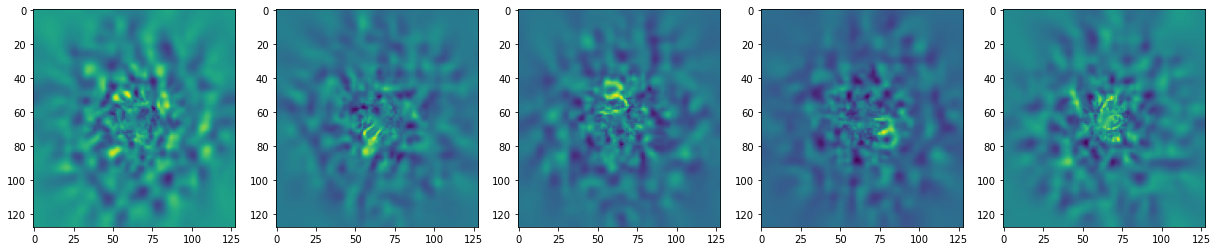

In [18]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 4))
for i_ax, ax in enumerate(axs):
    img_rec=inverse_gabor(data_big[i_ax, 0, :, :].detach(), K_inv)
    full_img_rec = inverse_pyramid(img_rec.unsqueeze(0), color=color, gauss=gauss, n_levels=n_levels)
    full_img_rec = full_img_rec.detach().permute(0,2,3,1).numpy()
    ax.imshow(full_img_rec.squeeze(), aspect='auto')